<a href="https://colab.research.google.com/github/dikshantshambharkar/Optical_Character_Recognition_using_Image/blob/main/OCR_using_Image(facebook).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**OPTICAL CHARACTER RECOGNITION USING IMAGE**

In this project , we will extract text from the images. After text extraction we will apply functions of OpenCV on text to enhance it and get more accurate results

Importing requests library for fetching the URL for git files and images

In [1]:
#import requests to install tesseract
import requests

Download tesseract which is required for pytesseract library to run and save the file at the path in open() function

In [5]:
# Downloading tesseract-ocr file
r = requests.get("https://raw.githubusercontent.com/tesseract-ocr/tessdata/4.00/ind.traineddata",stream = True)

# Writing data to file to avoid path issues
with open("/usr/share/tesseract-ocr/4.00/tessdata/ind.traineddata","wb") as file:
  for block in r.iter_content(chunk_size = 1024):
    if block:
      file.write(block)

Required Libraries

In [6]:
# installing libraries required for optical character recognition
! apt install tesseract-ocr libtesseract-dev libmagickwand-dev

#Importing IPython to clear output which is not important
from IPython.display import HTML, clear_output
clear_output()

In [7]:
# Installing pytesseract and opencv
! pip install pytesseract wand opencv-python
clear_output()

In [11]:
# Importing libraries
from PIL import Image                       #Open,Load,Download the image
import pytesseract                          #Library for extracting the text
import cv2                                  #OpenCV for Image Processing
import numpy as np                          #Computation
from pytesseract import Output              #provide the output format for the OCR result
import re                                   # Regular expressions -tool for pattern matching and string manipulation


Download Image from URl , save it and resize it and save again for further use and visualize it

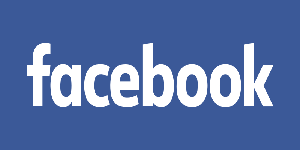

In [51]:
# Reading image from URL
image = Image.open(requests.get('https://upload.wikimedia.org/wikipedia/commons/thumb/7/7c/Facebook_New_Logo_%282015%29.svg/800px-Facebook_New_Logo_%282015%29.svg.png', stream=True).raw)
image = image.resize((300,150))
image.save('sample.png')
image

Extracting the text from the image with custom configuration.

In [52]:
# Simply extracting text from image
#custom_config = r'-l eng --oem 3 --psm 6'
#text = pytesseract.image_to_string(image,config=custom_config)
text = pytesseract.image_to_string(image)
print(text)

facebook



Removing the unwanted symbols from text

In [53]:
# Extracting text from image and removing irrelevant symbols from characters
try:
  text=pytesseract.image_to_string(image,lang="eng")
  characters_to_remove = "!()@-*><+-/\,.#$%^&~`_"
  new_string = text
  for character in characters_to_remove:
    new_string = new_string.replace(character,"")
  print(new_string)
except IOError as e:
  print("Error (%s)."% e)

facebook



Now we are reading the image into opencv format to process it further. This is required when we need to extract the text from complex images.

In [54]:
# Now we will perform opencv operations to ger text from complex images
image = cv2.imread('sample.png')

Converting the image to grayscale, it becomes less complex to process as it will have only two values 0 and 1. cv2.cvtColor() method is used to convert an image from color space to another.
There are more than 150 color-space conversion methods available in openCV

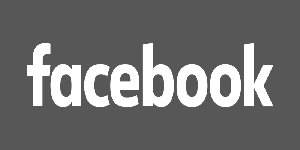

In [55]:
# get greyscale image
def get_grayscale(image):
  return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = get_grayscale(image)
Image.fromarray(gray)

Now we will blur the image to remove the noise from the image. The funvtion cv2.medianBlur() computes the median of all the pixels under the kernel window and the central pixel is replaced with this median value. This is highly effective in removing noise

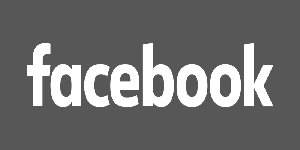

In [56]:
# noise removal
def remove_noise(image):
  return cv2.medianBlur(image,5)
noise = remove_noise(gray)
Image.fromarray(gray)

Now we will perform threshold transformation. If pixel value is greater than a threshold value, it is assigned one value (may be white), else it is assigned another value (may be black). The function used is cv2.threshold. First argument is the source image, which should be a grayscale image.

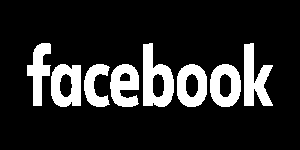

In [57]:
# thresholding
def thresholding(image):
  return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
thresh = thresholding(gray)
Image.fromarray(thresh)

Now erode Transformation. cv2.reode() method is used to perform erosion on the image. It erodes away the boundaries of foreground object(Always try to keep foreground in white). It is normally performed on binary images. It needs two inputs , original image and second one is called structuring element on kernel which decides the nature of operation.

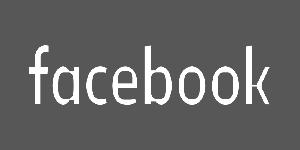

In [58]:
# erosion
def erode(image):
  kernel = np.ones((5,5),np.uint8)
  return cv2.erode(image,kernel,iterations = 1)
erode = erode(gray)
Image.fromarray(erode)

Here we will perform morphological transformation . It is useful in opening small holes inside the foreground objects, or small white points on the object

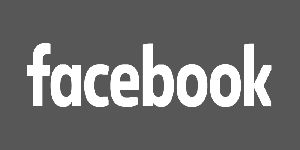

In [59]:
# Morphology
def opening(image):
  kernel = np.ones((5,5),np.uint8)
  return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
opening = opening(gray)
Image.fromarray(opening)

Canny transformation is used to detect edges in the image

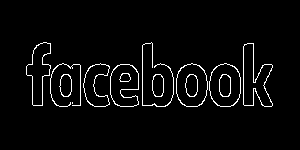

In [60]:
# canny edge detection
def canny(image):
  return cv2.Canny(image,100,200)
canny = canny(gray)
Image.fromarray(canny)

Now we will apply deskew on the image. Deskewing is a process whereby skew is removed by rotating an image by the same amount as its skew but in the opposite direction. This results in a horizontally and vertically aligned image where the text runs across the page rather than at an angle.

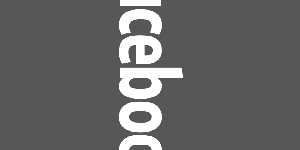

In [61]:
# skew correction
def deskew(image):
  coords = np.column_stack(np.where(image > 0))
  angle = cv2.minAreaRect(coords)[-1]
  if angle < -45:
    angle = -(90 + angle)
  else:
    angle = -angle
  (h,w) = image.shape[:2]
  center = (w // 2, h//2)
  M = cv2.getRotationMatrix2D(center, angle,1.0)
  rotated = cv2.warpAffine(image,M,(w,h), flags= cv2.INTER_CUBIC,borderMode=cv2.BORDER_REPLICATE)
  return rotated
rotated = deskew(gray)
Image.fromarray(rotated)

Now we will try to match the image.  Here, template matching is a method for searching and finding the loaction of a template image in a larger image. OpenCV comes with a function cv2.matchTemplate() for this purpose. It simply slides the template imag over the input image (as in 2D convolution) and compares the template and patch of input image under the template image.

In [62]:
# template matching
def match_template(image,template):
  return cv2.matchTemplate(image,template, cv2.TM_CCOEFF_NORMED)
match = match_template(gray, gray)
match

array([[1.]], dtype=float32)

Now we will segregate every character in the text by creating a rectangle around it .

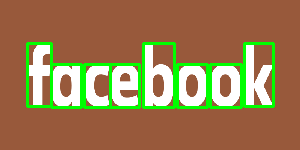

In [63]:
# Drawing rectangle ariund text
img = cv2.imread('sample.png')
h, w, c = img.shape
boxes = pytesseract.image_to_boxes(img)
for b in boxes.splitlines():
  b = b.split(' ')
  img = cv2.rectangle(img, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 2)
Image.fromarray(img)

Similarly we can draw rectangle around the specific pattern or word

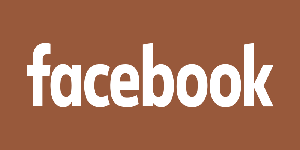

In [64]:
# Drawing pattern on specific pattern or word
img = cv2.imread('sample.png')
d = pytesseract.image_to_data(img, output_type=Output.DICT)
keys = list(d.keys())

date_pattern = 'artificially'

n_boxes = len(d['text'])
for i in range(n_boxes):
  if int(d['conf'][i]) > 60:
    if re.match(date_pattern, d['text'][i]):
      (x,y,w,h) = (d['left'][i],d['top'][i],d['width'][i],d['height'][i])
      img = cv2.rectangle(img, (x,y), (x+w,y+h), (0,255,0),2)
Image.fromarray(img)

**Conclusion** \
We learned about installing tesseract which was used for text extraction .Then we took an image and extracted the text. We also learned about image transformation functions of OpenCV in order to extract text from complex images.

**Scope**\
Organizations can use this to extract useful information from the image and store it. Individuals can use it foe saving their time and effort for typing